## **Xây dựng câu hỏi và Phân tích dữ liệu**

### **Khai báo thư viện**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import pi

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, KFold
from xgboost import XGBRegressor

### **Đọc file CSV**

In [314]:
# Đọc dữ liệu
df = pd.read_csv('../data/raw/spotify_dataset.csv')

# Xem 5 dòng đầu tiên
display(df.head())

# Tổng quan kích thước (Rows, Columns)
print(f"Số dòng: {df.shape[0]}")
print(f"Số cột: {df.shape[1]}")

# Kiểm tra kiểu dữ liệu và bộ nhớ
print("\nThông tin về kiểu dữ liệu")
df.info()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Số dòng: 114000
Số cột: 21

Thông tin về kiểu dữ liệu
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalne

## Câu 1: Công thức của một bài hát "Hit" là gì?

### Câu hỏi cụ thể
- Những đặc trưng âm thanh nào (**acousticness**, **danceability**, **energy**...) có mối tương quan tuyến tính mạnh nhất với độ phổ biến?
- Cấu trúc nhạc lý và thể loại nội dung có ảnh hưởng đến độ phổ biến của bài hát không?
- Có sự khác biệt rõ rệt nào về đặc tính âm thanh giữa nhóm bài hát Hit (Popularity > 75) và nhóm Non-Hit (Popularity < 25) không?

### Tại sao câu hỏi này đáng nghiên cứu?
- Việc xác định các yếu tố tạo nên thành công giúp chúng ta hiểu được thị hiếu của đại chúng hiện nay, từ đó định hướng cho quá trình sản xuất.

### Việc trả lời câu hỏi này sẽ mang lại lợi ích hoặc hiểu biết gì?
- Giúp các nhà sản xuất tập trung nguồn lực vào các yếu tố kỹ thuật quan trọng nhất (ví dụ: nên tăng bass, tăng nhịp độ hay làm nhạc acoustic?).

### Ai sẽ quan tâm đến câu trả lời?
- Nhà sản xuất âm nhạc, Nghệ sĩ, và các hãng thu âm

### Câu trả lời này giúp giải quyết vấn đề hoặc quyết định thực tế nào?
- Tối ưu hóa khả năng thành công thương mại của một sản phẩm âm nhạc mới ra mắt.

### Phân tích và Trực quan hóa

**Phương pháp phân tích**

- **Chọn đặc trưng:**
    - Để có cái nhìn toàn diện, chúng tôi phân loại và sử dụng 3 nhóm biến số chính:
    - **Đặc trưng âm thanh (Audio Features):** danceability, energy, loudness, speechiness, acousticness, instrumentalness, valence, tempo, duration_ms, liveness.
    - **Đặc trưng nhạc lý (Musical Features):** key, mode, time_signature.
    - **Đặc trưng thể loại nội dung (Metadata):** track_genre, explicit.

- **Xử lý và Phân nhóm dữ liệu:**
    - **Làm sạch:** Loại bỏ các quan sát nhiễu có giá trị bằng 0 ở các cột time_signature, tempo, duration_ms.
    - **Chuẩn hóa:** Sử dụng MinMaxScaler để đưa các đặc trưng âm thanh về cùng một thang đo [0, 1]. Việc này nhằm loại bỏ sự chênh lệch đơn vị (ví dụ: Loudness vs Tempo), phục vụ cho việc vẽ biểu đồ Radar sau này.
    - **Phân loại Hit/Non-Hit:** Tách dữ liệu thành 2 nhóm cực để so sánh:
        - **Nhóm Hit:** Các bài hát có popularity > 75.
        - **Nhóm Non-Hit:** Các bài hát có popularity < 25.

- **Trực quan hóa:**
- **Sử dụng:** Barplot, Boxplot và Radar Chart.
- **Lý do:**
    - **Barplot/Boxplot:** So sánh phân phối và độ phổ biến trung bình giữa các nhóm đặc trưng âm thanh, nhóm thể loại và đặc tính nhạc lý.
    - **Radar Chart:** Là công cụ trực quan hóa đa biến, giúp quan sát hình dáng hay hồ sơ âm thanh tổng thể của một bài hát Hit so với bài Non-Hit trên cùng một hệ quy chiếu.

- **Phương pháp thống kê:**
    - **Sử dụng:** Hệ số tương quan Pearson và Spearman.
    - **Lý do:**
        - **Pearson:** Đo lường mối quan hệ tuyến tính giữa đặc trưng âm thanh và độ phổ biến.
        - **Spearman:** Đo lường mối quan hệ thứ bậc.
        - **So sánh hiệu số (Pearson - Spearman):** Nhằm phát hiện các mối quan hệ phức tạp mà tương quan tuyến tính đơn thuần có thể bỏ sót.

- **Kết quả đầu ra:**
    - **Bảng hệ số tương quan:** Xếp hạng các đặc trưng có ảnh hưởng tích cực hoặc tiêu cực nhất đến độ phổ biến.
    - **Biểu đồ phân nhóm:** Top các thể loại nhạc thịnh hành nhất và kém thịnh hành nhất.
    - **Hồ sơ âm thanh:**
        - **Nhận diện mẫu:** So sánh diện tích và hình dạng bao phủ trên biểu đồ Radar giữa nhóm Hit và Non-Hit.
        - **Giả định quan sát:**
            - **Nếu vùng màu xanh (Hit) mở rộng về phía trục Energy/Danceability:** Bài hát phổ biến có xu hướng sôi động.
            - **Nếu vùng màu xanh co cụm khác biệt hoàn toàn với vùng màu xám (Non-Hit):** Tồn tại một công thức âm thanh cụ thể cho sự thành công.

#### Xác định các đặc trưng phân tích

In [315]:
feats_audio = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "duration_ms", "liveness"]
feats_binary_musical = ["mode"]
feats_ordinal_musical = ["key", "time_signature"]
feats_nominal_metadata = "track_genre"
feats_binary_metadata = "explicit"
target_col = "popularity"

print("Các đặc trưng âm thanh:", feats_audio)
print("Các đặc trưng nhạc lý:", feats_binary_musical + feats_ordinal_musical)
print("Các đặc trưng phân loại nội dung:", feats_nominal_metadata + feats_binary_metadata)

Các đặc trưng âm thanh: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms', 'liveness']
Các đặc trưng nhạc lý: ['mode', 'key', 'time_signature']
Các đặc trưng phân loại nội dung: track_genreexplicit


#### Tiền xử lý dữ liệu

Xóa các dữ liệu vô lý (các đặc trưng **time_signature**, **tempo**, **duration_ms** bằng 0).

In [ ]:
# Sao chép dataframe để xử lý
df_copy = df.copy()

df_copy = df_copy.drop(df_copy[df_copy['time_signature'] == 0].index)
df_copy = df_copy.drop(df_copy[df_copy['tempo'] == 0].index)
df_copy = df_copy.drop(df_copy[df_copy['duration_ms'] == 0].index)

# Tổng quan kích thước (Rows, Columns)
print(f"Số dòng mới: {df_copy.shape[0]}")
print(f"Số cột mới: {df_copy.shape[1]}")

Số dòng mới: 113836
Số cột mới: 21


Vì hầu hết các đặc trưng số đều nằm trong khoảng (0-1) nên thực hiện chuẩn hóa Min-Max toàn bộ đặc trưng số để đồng bộ dữ liệu.

In [317]:
scaler = MinMaxScaler()
df_copy[feats_audio] = scaler.fit_transform(df_copy[feats_audio])
for col in feats_audio:
    print("="* 10+f"Đặc trưng {col}" + "="* 10)
    print(f"Trước chuẩn hóa:")
    print(f"    Min: {df[col].min()}")
    print(f"    Max: {df[col].max()}")
    print(f"Sau chuẩn hóa:")
    print(f"    Min: {df_copy[col].min()}")
    print(f"    Max: {df_copy[col].max()}")

==========Đặc trưng danceability==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 0.985
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng energy==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 1.0
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng loudness==========
Trước chuẩn hóa:
    Min: -49.531
    Max: 4.532
Sau chuẩn hóa:
    Min: 0.0
    Max: 0.9999999999999999
==========Đặc trưng speechiness==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 0.965
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng acousticness==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 0.996
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng instrumentalness==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 1.0
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng valence==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 0.995
Sau chuẩn hóa:
    Min: 0.0
    Max: 0.9999999999999999
==========Đặc trưng tempo==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 243.

#### Những đặc trưng âm thanh nào (**acousticness**, **danceability**, **energy**...) có mối tương quan tuyến tính mạnh nhất với độ phổ biến?

Phân tích hệ số tương quan

In [318]:
df_factor_numerical = df_copy[feats_audio + [target_col]]

# Tính hệ số tương quan Pearson
correlation_pearson = df_factor_numerical.corr(method='pearson')[target_col].sort_values(ascending=False)
correlation_pearson = correlation_pearson.drop(target_col)

# Tính hệ số tương quan Spearman
correlation_spearman = df_factor_numerical.corr(method='spearman')[target_col].sort_values(ascending=False)
correlation_spearman = correlation_spearman.drop(target_col)

# Tính sự khác biệt giữa hai phương pháp
diff_correlation = (correlation_pearson - correlation_spearman).sort_values(ascending=False)

# In ra kết quả
print("="*10 + "Hệ số tương quan Pearson với độ phổ biến" + "="*10)
print(correlation_pearson)

print("\n" + "="*10 + "Hệ số tương quan Spearman với độ phổ biến" + "="*10)
print(correlation_spearman)

print("\n" + "="*10 + "Sự khác giữa hai phương pháp tính hệ số tương quan" + "="*10)
print(diff_correlation)

==========Hệ số tương quan Pearson với độ phổ biến==========
loudness            0.051499
danceability        0.036511
tempo               0.014369
energy              0.001531
liveness           -0.005683
duration_ms        -0.006960
acousticness       -0.025554
valence            -0.040191
speechiness        -0.044763
instrumentalness   -0.095887
Name: popularity, dtype: float64

==========Hệ số tương quan Spearman với độ phổ biến==========
loudness            0.035536
duration_ms         0.028452
danceability        0.026993
tempo               0.017493
acousticness        0.008394
liveness           -0.008333
energy             -0.023258
valence            -0.041630
speechiness        -0.067602
instrumentalness   -0.078860
Name: popularity, dtype: float64

==========Sự khác giữa hai phương pháp tính hệ số tương quan==========
energy              0.024789
speechiness         0.022839
loudness            0.015963
danceability        0.009518
liveness            0.002649
valence      

Trực quan hóa hệ số tương quan

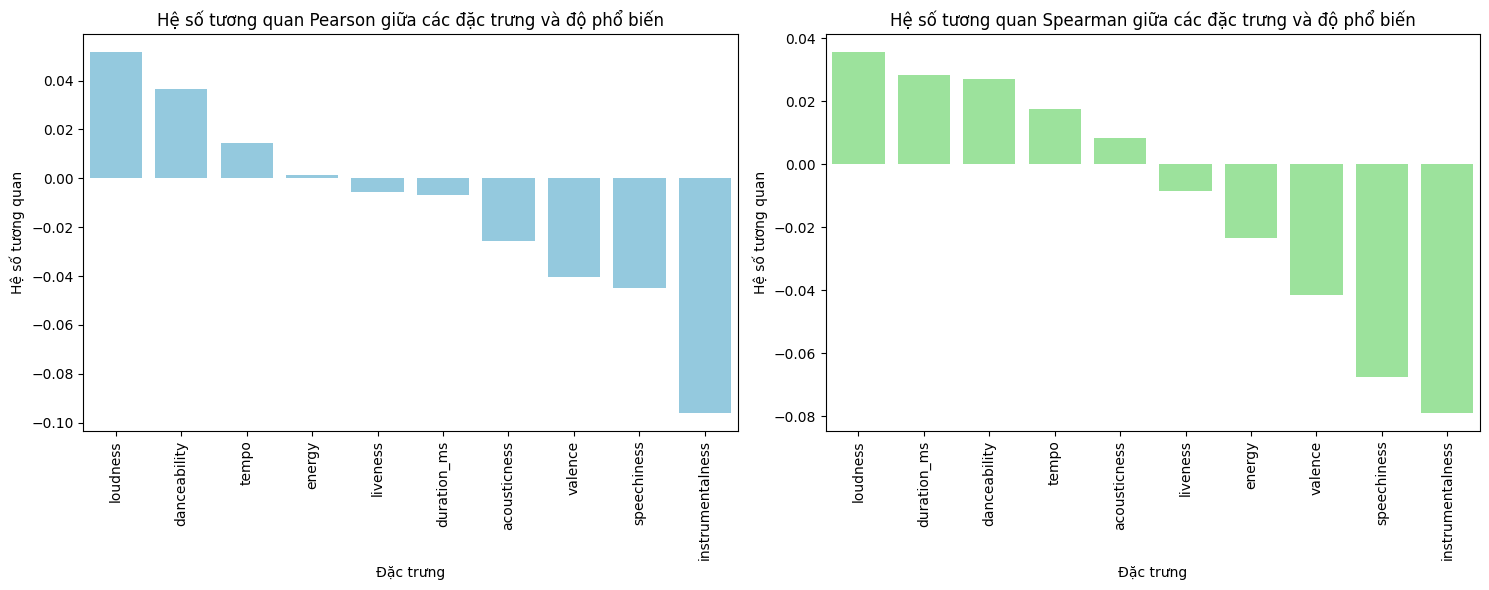

In [319]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
sns.barplot(x=correlation_pearson.index, y=correlation_pearson.values, color='skyblue')
plt.title('Hệ số tương quan Pearson giữa các đặc trưng và độ phổ biến')
plt.ylabel('Hệ số tương quan')
plt.xlabel('Đặc trưng')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.barplot(x=correlation_spearman.index, y=correlation_spearman.values, color='lightgreen')
plt.title('Hệ số tương quan Spearman giữa các đặc trưng và độ phổ biến')
plt.ylabel('Hệ số tương quan')
plt.xlabel('Đặc trưng')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

- Nhận xét tổng quan:
    - Hầu hết các hệ số tương quan đều cực kỳ gần 0.
    - Đặc trưng có độ lớn tuyệt đối của hệ số tương quan cao nhất là `instrumentalness` (~0.09). Các đặc trưng còn lại đều có độ lớn tuyệt đối loanh quanh 0.01-0.05.
    - Các đặc trưng âm thanh khi đứng một mình hầu như không có mỗi quan hệ tuyến tính hay đơn điều nào với độ phổ biến.
- Sự chênh lệch giữa hệ số tương quan Pearson và Spearman:
    - Không có mối quan hệ tuyến tính hay phi tuyến tính mạnh: Vì hệ số tương quan của Pearson và Spearman thấp như nhau. Do đó, dữ liệu có khả năng phân tán ngẫu nhiên so với biến `popularity`.
    - Dữ liệu khá ổn định về mặt phân phối: Ít có khả năng một bài hát ngoại lai làm sai sai lệch hoàn toàn kết quả, do Pearson và Spearman chênh lệch ít ở hầu hết các biến, cho thấy dữ liệu khá ổn định.
    - Tuy nhiên, `acousticness` và `energy` có sự đổi dấu hệ số tương quan giữa Pearson và Spearman. Điều này gợi ý rằng mối quan hệ giữa chúng và độ phổ biến không đồng nhất trên toàn bộ tập dữ liệu, và bị ảnh hưởng bởi các giá trị ngoại lai
- Các đặc trưng nổi bật:
    - `instrumentalness` và `speechiness`: Hai yếu tố có tương quan âm rõ rệt nhất. Nhạc không lời hoặc nhạc chứa quá nhiều từ ngữ thường khó đạt độ phổ biến cao.
    - `loudness` và `danceability`: Có tương quan dương nhất quán. Nhạc to, dễ nhảy dễ tiếp cận khán giả đại chúng hơn.

#### Cấu trúc nhạc lý có ảnh hưởng đến độ phổ biến của bài hát không?

Thống kê các đặc trưng

In [320]:
feats_musical = feats_ordinal_musical + feats_binary_musical
for col in feats_musical:
    avg_popularity_by_col = df_copy.groupby(col)['popularity'].mean().sort_values(ascending=False)
    print("\n" + "="*10 + f"Độ phổ biến trung bình theo {col}" + "="*10)
    print(avg_popularity_by_col)


==========Độ phổ biến trung bình theo key==========
key
4     34.643936
2     34.370785
11    33.889464
6     33.579426
1     33.188681
3     33.030864
8     32.954805
5     32.930784
9     32.819589
7     32.582729
0     32.512113
10    32.431380
Name: popularity, dtype: float64

==========Độ phổ biến trung bình theo time_signature==========
time_signature
4    33.672807
3    29.692442
1    29.073998
5    28.778204
Name: popularity, dtype: float64

==========Độ phổ biến trung bình theo mode==========
mode
0    33.645762
1    32.999035
Name: popularity, dtype: float64


Trực quang hóa giá trị trung bình

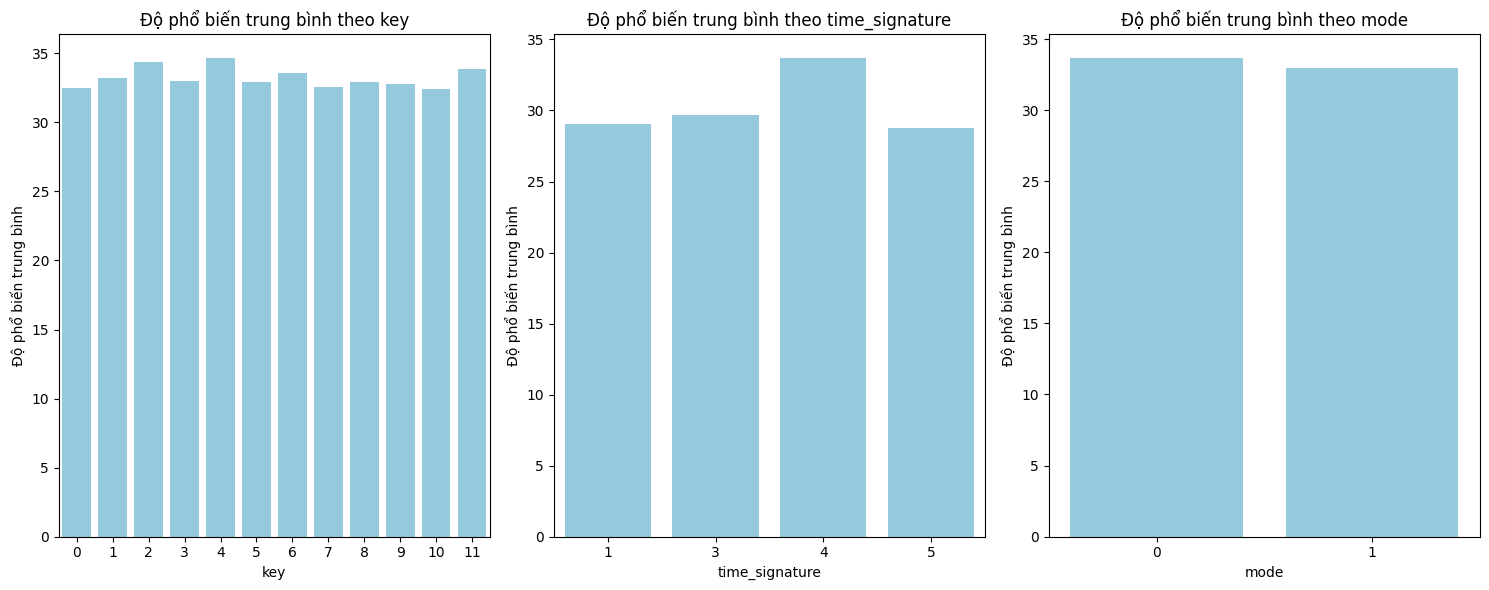

In [321]:
# Tính toán kích thước lưới biểu đồ
plots = len(feats_musical)
cols = 3  # Số biểu đồ trên 1 hàng
rows = math.ceil(plots / cols)  # Tự động tính số hàng cần thiết

# Vẽ biểu đồ
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows)) # Điều chỉnh kích thước tổng thể
axes = axes.flatten()

for i, col in enumerate(feats_musical):
    avg_popularity_by_col = df_copy.groupby(col)['popularity'].mean().reset_index()
    sns.barplot(data=df_copy, x=col, y=target_col, ax=axes[i], color='skyblue', errorbar=None)

    axes[i].set_title(f'Độ phổ biến trung bình theo {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Độ phổ biến trung bình')

# Ẩn các ô biểu đồ thừa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **Độ phổ biến theo Key**
    - **Quan sát:** Chiều cao của các cột từ Key 0 đến Key 11 rất đồng đều, dao động nhẹ trong khoảng giá trị y từ 32 đến 35. Không có một Key nào nổi trội vượt bậc về độ phổ biến.
    - **Nhận xét:**
        - Biến thiên của độ phổ biến giữa các Key là rất thấp.
        - Key 2 và Key 4 có vẻ nhỉnh hơn một chút nhưng không đáng kể về mặt thống kê dựa trên trực quan.
    - **Key** của bài hát không phải là yếu tố quyết định đến việc bài hát đó có phổ biến hay không. Người nghe đại chúng không thiên vị cụ thể một tông nhạc nào.
- **Độ phổ biến theo time_signature**
    - **Quan sát:** Có sự chênh lệch rõ ràng hơn.
        - `time_signature = 4` có độ phổ biến trung bình cao nhất (đạt gần mức 34-35).
        - `time_signature = 3` đứng thứ hai (khoảng 30).
        - `time_signature = 1` và `5` có độ phổ biến thấp nhất (dưới 30).
    - **Nhận xét:**
        - Nhịp 4 là nhịp tiêu chuẩn và phổ biến nhất trong âm nhạc hiện đại, dễ nghe và dễ bắt tai, điều này lý giải cho chỉ số phổ biến cao nhất.
        - Nhịp 3 cũng khá phổ biến nhưng kén hơn nhịp 4.
        - Các nhịp phức tạp hoặc lạ (1, 5) thường khó tiếp cận đại chúng hơn, dẫn đến độ phổ biến trung bình thấp hơn.
    - **time_signature** là một đặc trưng có ý nghĩa để dự đoán độ phổ biến.
- **Độ phổ biến theo Mode**
    - **Quan sát:** Hai cột 0 và 1 có chiều cao gần như bằng nhau (xấp xỉ 33-34).
    - **Nhận xét:** Dù bài hát mang âm hưởng Trưởng (Major - thường vui tươi) hay Thứ (Minor - thường buồn bã), thì cơ hội để trở nên phổ biến là như nhau.
    - **mode** có tương quan rất yếu hoặc không có tương quan với độ phổ biến trung bình.

Trực quan hóa độ phân tán của dữ liệu

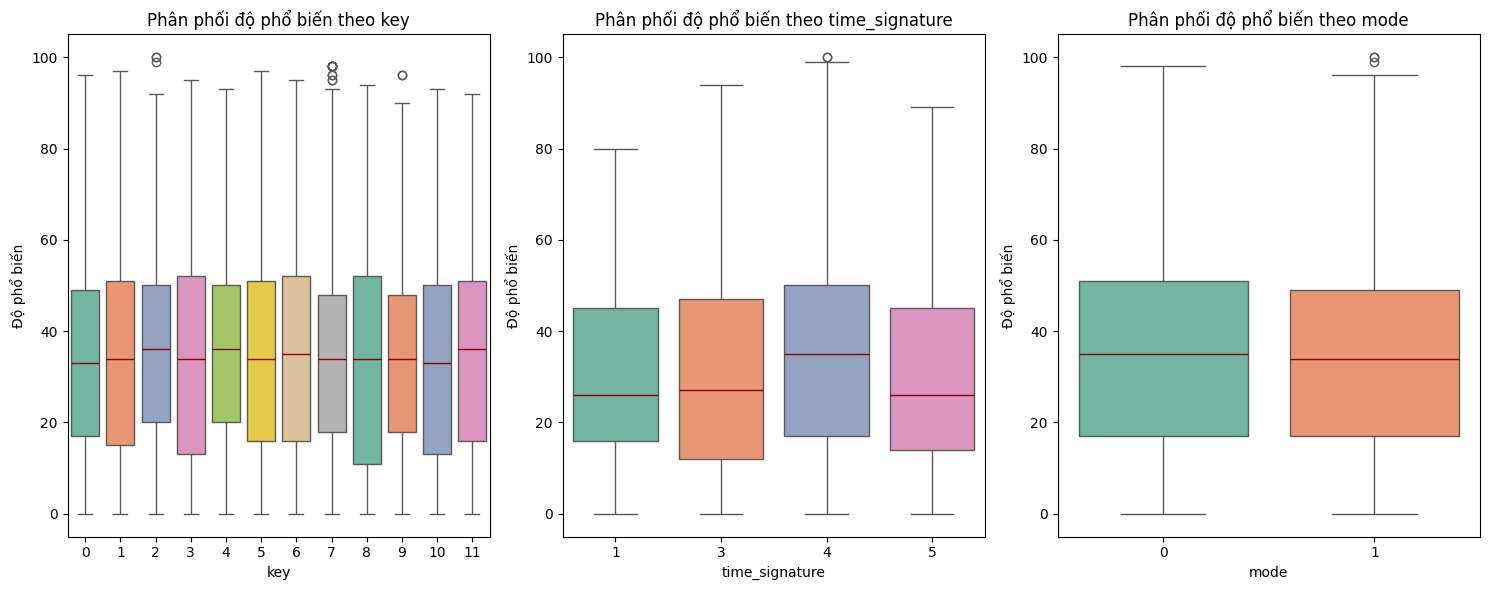

In [322]:
# Tính toán kích thước lưới biểu đồ
plots = len(feats_musical)
cols = 3  # Số biểu đồ trên 1 hàng
rows = math.ceil(plots / cols)  # Tự động tính số hàng cần thiết

# Vẽ biểu đồ
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows)) # Điều chỉnh kích thước tổng thể
axes = axes.flatten()

for i, col in enumerate(feats_musical):
    sns.boxplot(data=df_copy, x=col, y=target_col, ax=axes[i], hue=col, palette='Set2', legend=False, medianprops={'color': 'darkred'})

    axes[i].set_title(f'Phân phối độ phổ biến theo {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Độ phổ biến')

# Ẩn các ô biểu đồ thừa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **Phân phối theo Key**
    - **Trung vị:** Khá ổn định giữa các Key, dao động quanh mức 35-40. Không có Key nào có trung vị vượt trội hẳn.
    - **Độ trải giữa (IQR):** Các hộp có chiều cao tương đương nhau, cho thấy mức độ biến động của độ phổ biến là như nhau ở mọi tông nhạc.
    - **Giá trị ngoại lai:** Xuất hiện các điểm tròn ở phía trên (mức 90-100) ở một số Key (như 2, 7, 9). Điều này chứng tỏ các bài hát cực kỳ phổ biến có thể xuất hiện ngẫu nhiên ở các Key này, nhưng là trường hợp hiếm chứ không phải xu hướng chung.

- **Phân phối theo time_signature**
    - **Sự khác biệt rõ rệt:** Đây là biểu đồ có thông tin giá trị nhất.
    - **Time_signature = 4:**
        - Có trung vị cao nhất (xấp xỉ 35-38).
        - Có Outlier đạt mức gần 100.
    - **Time_signature = 1, 3, 5:** Có phân phối lệch về phía thấp hơn (Median khoảng 25). Đặc biệt nhịp 3 có hộp khá thấp, cho thấy phần lớn các bài hát nhịp này khó đạt độ phổ biến cao.

- **Phân phối theo mode**
    - **Sự tương đồng:** Hai hộp biểu diễn Mode 0 và 1 gần như giống hệt nhau về cả Trung vị, IQR và khoảng biên.
    - **Kết luận:** **mode** hoàn toàn không phân tách được độ phổ biến. Dữ liệu này khẳng định lại nhận định ở biểu đồ cột trước đó: Âm hưởng vui/buồn không quyết định thành bại của bài hát.

#### Thể loại nội dung có ảnh hưởng đến độ phổ biến của bài hát không?

Đặc trưng Nominal

Độ phổ biến trung bình của các thể loại hàng đầu và ít được biết tới nhất.

In [323]:
avg_popularity_by_genre = df_copy.groupby('track_genre')['popularity'].mean().sort_values(ascending=False).reset_index()
print("="*10 + "Top 10 thể loại nhạc phổ biến nhất" + "="*10)
display(avg_popularity_by_genre.head(10))
print("\n" + "="*10 + "Top 10 thể loại nhạc ít phổ biến nhất" + "="*10)
display(avg_popularity_by_genre.tail(10))

==========Top 10 thể loại nhạc phổ biến nhất==========


,track_genre,popularity
0,pop-film,59.283000
1,k-pop,56.952953
2,chill,53.651000
3,sad,52.379000
4,grunge,49.594000
5,indian,49.539000
6,anime,48.772000
7,emo,48.128000
8,sertanejo,47.866000
9,pop,47.576000



==========Top 10 thể loại nhạc ít phổ biến nhất==========


,track_genre,popularity
104,idm,15.766000
105,kids,14.888000
106,grindcore,14.625000
107,jazz,13.579580
108,classical,13.055000
109,chicago-house,12.339000
110,detroit-techno,11.174000
111,latin,8.297000
112,romance,3.222222
113,iranian,2.218876


Trực quan hóa độ phổ biến trung bình của các nhóm thể loại (Chia theo xếp hạng độ phổ biến)

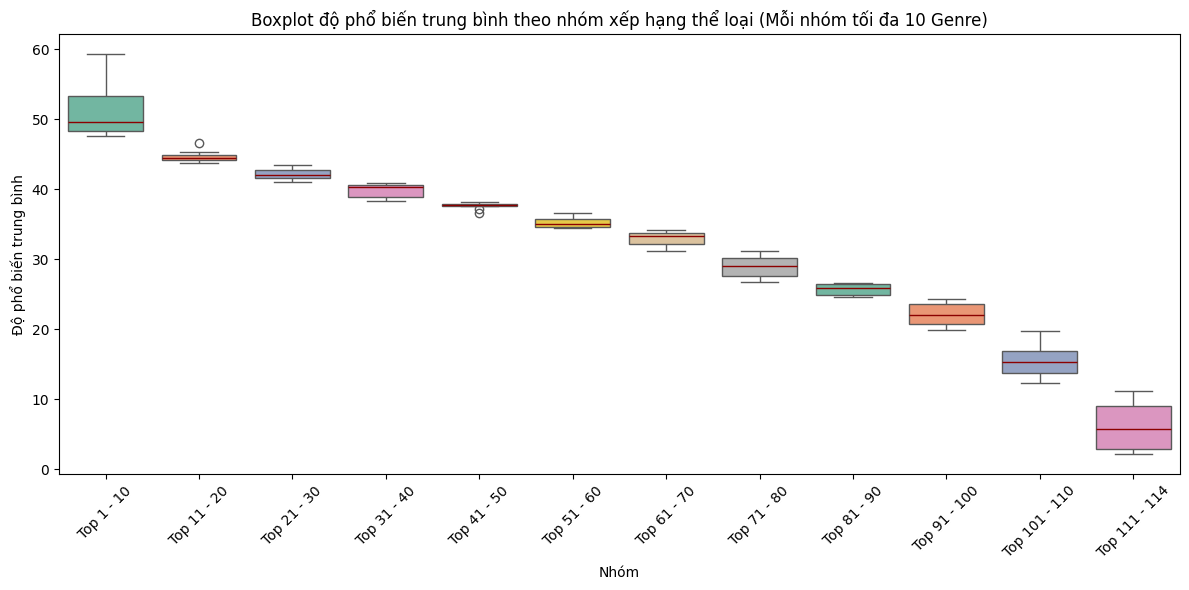

In [324]:
# Tạo dictionary ánh xạ từ genre sang nhóm
genre_to_group = {}
group_size = 10

for i, genre in enumerate(avg_popularity_by_genre['track_genre']):
    group_num = i // group_size + 1
    genre_to_group[genre] = f'Top {(group_num-1)*group_size + 1} - {min(len(avg_popularity_by_genre), (group_num)*group_size)}'

# Thêm cột nhóm
avg_popularity_by_genre['genre_group'] = avg_popularity_by_genre['track_genre'].map(genre_to_group)

# Sắp xếp các nhóm theo thứ tự top tăng dần
group_order = sorted(avg_popularity_by_genre['genre_group'].unique(), 
                     key=lambda x: int(x.split()[1]))

# Vẽ boxplot
plt.figure(figsize=(12, 6))

sns.boxplot(data=avg_popularity_by_genre, x='genre_group', y='popularity', order=group_order, hue='genre_group', palette='Set2', medianprops={'color': 'darkred'})
plt.title('Boxplot độ phổ biến trung bình theo nhóm xếp hạng thể loại (Mỗi nhóm tối đa 10 Genre)')
plt.xlabel('Nhóm')
plt.ylabel('Độ phổ biến trung bình')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- **Độ biến thiên:**
    - **Nhóm Top 1-10:** Có IQR khá rộng và whiskers dài. Điều này cho thấy ngay cả trong top 10 thể loại hot nhất, vẫn có sự chênh lệch lớn về độ phổ biến (từ khoảng 48 đến 60).
    - **Nhóm giữa (Top 31-60):** Các hộp rất dẹt (khoảng biến thiên hẹp). Điều này nghĩa là các thể loại trong phân khúc này có độ phổ biến rất đồng đều, ít sự khác biệt.
    - **Nhóm cuối (Top 101-114):** Hộp lại bắt đầu giãn ra và giá trị giảm mạnh về gần 0.
- **Giá trị ngoại lai (Outliers):**
    - Xuất hiện các điểm tròn nhỏ ở các nhóm như Top 11-20 và Top 41-50. Đây là các thể loại có độ phổ biến cao hoặc thấp bất thường so với nhóm của nó.

Trực quan hóa độ phổ biến trung bình cho nhóm phổ biến nhất (top 1-10) và nhóm ít phổ biến nhất (top 111-114)

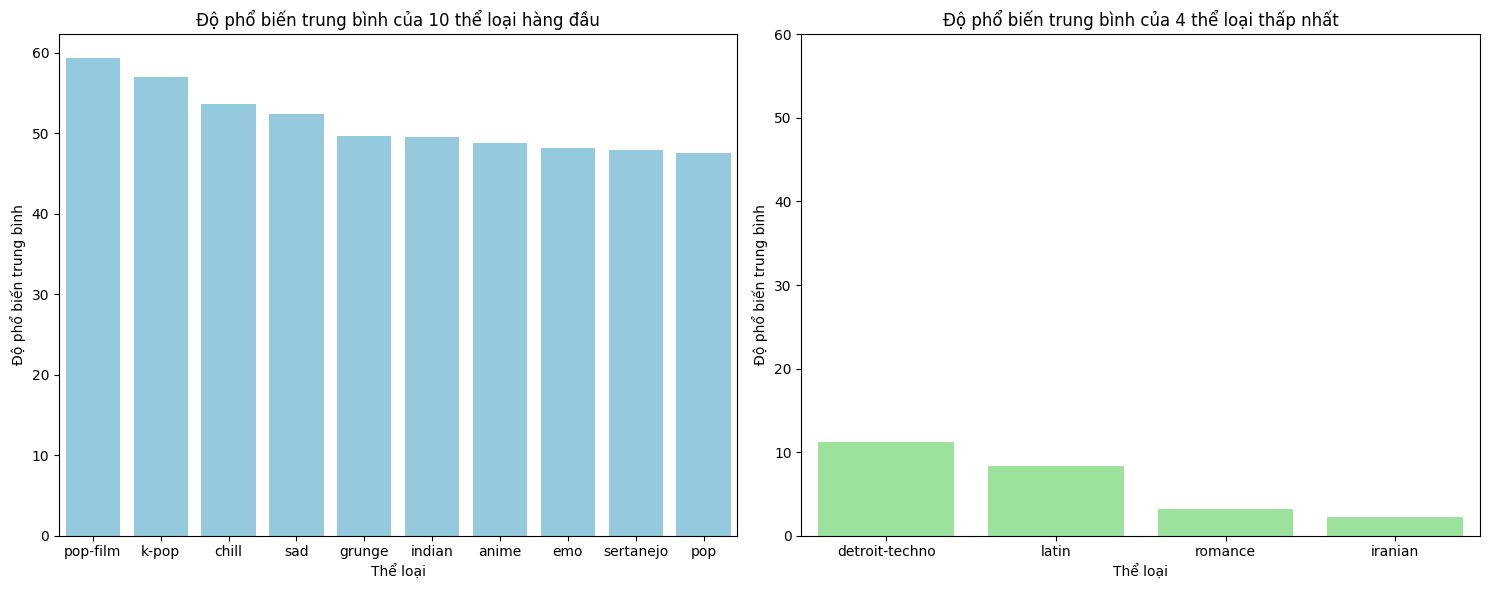

In [325]:
top_10 = avg_popularity_by_genre.head(10)
bottom_4 = avg_popularity_by_genre.tail(4)

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
sns.barplot(x=top_10['track_genre'], y=top_10['popularity'], color='skyblue')
plt.title('Độ phổ biến trung bình của 10 thể loại hàng đầu')
plt.ylabel('Độ phổ biến trung bình')
plt.xlabel('Thể loại')

plt.subplot(1,2,2)
sns.barplot(x=bottom_4['track_genre'], y=bottom_4['popularity'], color='lightgreen')
plt.title('Độ phổ biến trung bình của 4 thể loại thấp nhất')
plt.ylabel('Độ phổ biến trung bình')
plt.xlabel('Thể loại')

plt.ylim(0, 60)
plt.tight_layout()
plt.show()

- **Nhóm Top 10:**
    - **Dải giá trị:** Rất cao và khá đồng đều, dao động từ khoảng 48 đến 60.
    - **Thứ hạng:** pop-film dẫn đầu (gần 60), theo sát là k-pop, chill, và sad.
    - **Đặc điểm:** Sự chênh lệch giữa vị trí số 1 (pop-film) và số 10 (pop) không quá lớn (khoảng 10-12 điểm).
- **Nhóm Bottom 4:**
    - **Dải giá trị:** Rất thấp, max chỉ khoảng 11 và min xuống gần 2.
    - **Thứ hạng:** detroit-techno (~11), latin (~8), romance (~3), iranian (~2).
    - **Đặc điểm:** Có sự sụt giảm nghiêm trọng. Ví dụ: detroit-techno cao gấp 5 lần iranian.
- **Nhận xét:** Nhìn chung xu hướng "Mood and Context" lên ngôi.
    - **Pop-film đứng đầu:** Điều này cho thấy người dùng có xu hướng nghe nhạc gắn liền với ngữ cảnh hoặc thương hiệu phim ảnh. Nhạc phim thường có độ viral cao nhờ hiệu ứng từ phim.
    - **Sự trỗi dậy của Mood Music:** Các thể loại chill, sad thực chất là trạng thái cảm xúc hơn là thể loại nhạc thuần túy về kỹ thuật. Việc chúng nằm trong Top 5 cho thấy người dùng ngày nay tìm kiếm nhạc để phục vụ cảm xúc hoặc làm nền cho hoạt động nhiều hơn là tìm kiếm theo dòng nhạc cụ thể.
    - Ngoài ra thì các dòng nhạc liên quan đến Pop cũng có khả năng trở nên viral rất cao.

Đặc trưng Binary

Thống kê

In [326]:
avg_popularity_by_col = df.groupby(feats_binary_metadata)['popularity'].mean().sort_values(ascending=False)
print("\n" + "="*10 + f"Độ phổ biến trung bình theo {feats_binary_metadata}" + "="*10)
print(avg_popularity_by_col)


==========Độ phổ biến trung bình theo explicit==========
explicit
True     36.454191
False    32.937891
Name: popularity, dtype: float64


Trực quan hóa độ phổ biến trung bình

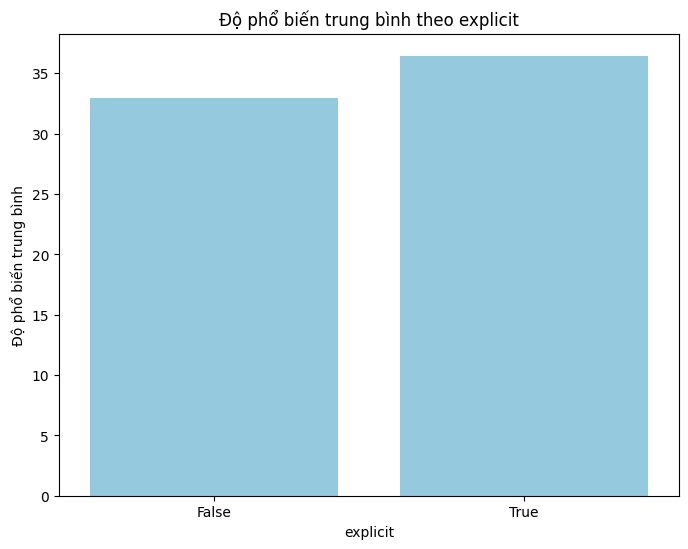

In [327]:
# Vẽ barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_popularity_by_col.index, y=avg_popularity_by_col.values, color='skyblue')
plt.title(f'Độ phổ biến trung bình theo {feats_binary_metadata}')
plt.ylabel('Độ phổ biến trung bình')
plt.xlabel(feats_binary_metadata)
plt.show()

- **Sự chênh lệch:** Có sự khác biệt về độ phổ biến trung bình giữa hai nhóm. Các bài hát/nội dung được dán nhãn `explicit=True` có độ phổ biến cao hơn so với nhóm `explicit=False`.
- **Độ lớn:** Mức chênh lệch rơi vào khoảng 3-4 điểm. Đây không phải là mức chênh lệch quá lớn.
- Có thể các thể loại nhạc thịnh hành hiện nay thường chứa nhiều nội dung nhạy cảm. Chính thể loại nhạc mới là yếu tố kéo độ phổ biến lên, còn nội dung nhạy cảm chỉ là đặc tính đi kèm của thể loại đó.

Trực quan phân phối của độ phổ biến

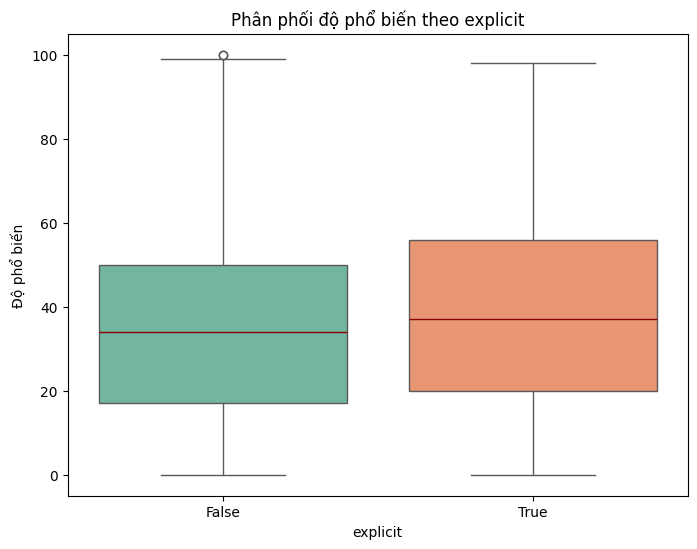

In [328]:
# Vẽ boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_copy, x=feats_binary_metadata, y='popularity', hue=feats_binary_metadata, palette='Set2', medianprops={'color': 'darkred'}, legend=False)
plt.title(f'Phân phối độ phổ biến theo {feats_binary_metadata}')
plt.xlabel(feats_binary_metadata)
plt.ylabel('Độ phổ biến')
plt.show()

- **Trung vị cao hơn:** Đường màu đỏ của nhóm True nằm cao hơn nhóm False. Điều này khẳng định lại nhận định ở biểu đồ trước: Nhạc có nội dung nhạy cảm có xu hướng phổ biến hơn, ngay cả khi loại bỏ ảnh hưởng của các giá trị cực đoan.
- **Độ phân tán:** Cả hai nhóm đều có độ phân tán rất rộng (từ 0 đến gần 100). Điều này cho thấy tính chất explicit không đảm bảo một bài hát sẽ thành hit, nó chỉ nhích nhẹ khả năng đó lên thôi.
- **Vùng tập trung dữ liệu:** Hộp màu cam (True) nằm cao hơn hộp màu xanh (False) một chút. 50% số bài hát explicit nằm trong khoảng điểm 20-55, trong khi 50% bài hát không explicit nằm trong khoảng 18-50.
- Một bài hát dán nhãn Explicit có xác suất bị rơi vào nhóm kém phổ biến thấp hơn một chút so với bài hát thường. Có thể hiểu là nội dung Explicit có một lượng khán giả trung thành giúp giữ nhiệt cho bài hát tốt hơn là các bài nhạc thường nhưng nhạt nhòa.

#### Có sự khác biệt rõ rệt nào về đặc tính âm thanh giữa nhóm bài hát Hit (Popularity > 75) và nhóm Non-Hit (Popularity < 25) không?

Xác định các bài hát Hit và Non-Hit

In [329]:
df_hit = df_copy[df_copy['popularity'] > 75]
df_non_hit = df_copy[df_copy['popularity'] < 25]

print(f"Số lượng bài hát Hit: {df_hit.shape[0]} | Tỷ lệ: {df_hit.shape[0]/df_copy.shape[0]:.2%}")

print(f"Số lượng bài hát Non-Hit: {df_non_hit.shape[0]} | Tỷ lệ: {df_non_hit.shape[0]/df_copy.shape[0]:.2%}")

Số lượng bài hát Hit: 2412 | Tỷ lệ: 2.12%
Số lượng bài hát Non-Hit: 42806 | Tỷ lệ: 37.60%


Trực quan hóa

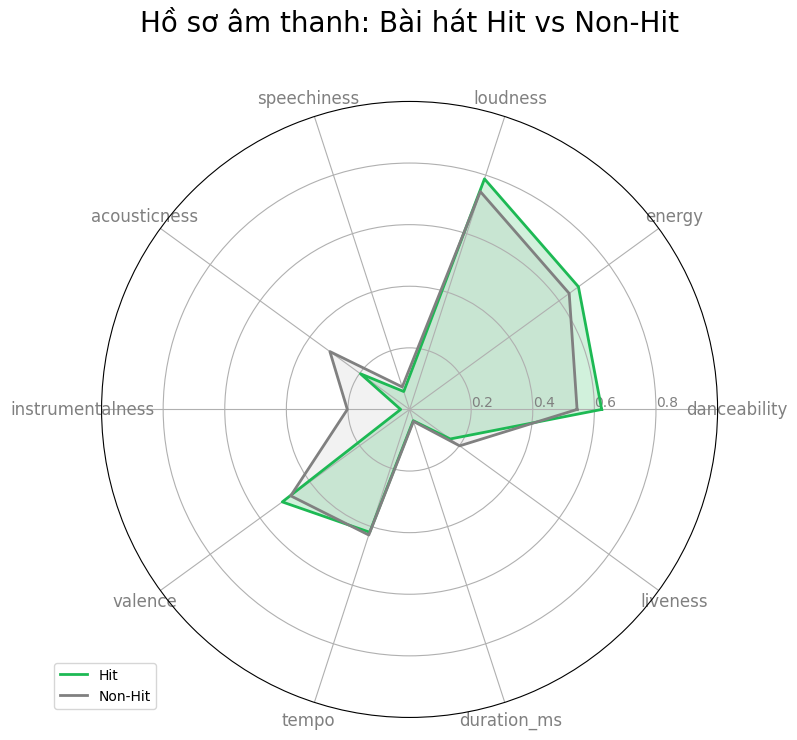

In [330]:
num_feat = len(feats_audio)

# Tính góc cho mỗi trục (chia tròn 360 độ thành N phần)
angles = [n / float(num_feat) * 2 * pi for n in range(num_feat)]
angles += angles[:1] # Đóng vòng tròn lại (nối điểm cuối về điểm đầu)

# Khởi tạo biểu đồ Polar
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Vẽ trục cho mỗi biến
plt.xticks(angles[:-1], feats_audio, color='grey', size=12)

# Vẽ trục y (các vòng tròn đồng tâm)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
plt.ylim(0, 1) # Giới hạn giá trị từ 0 đến 1

# --- Vẽ nhóm HIT ---
values_hit = df_hit[feats_audio].mean().values.tolist()
values_hit += values_hit[:1] # Đóng vòng tròn
ax.plot(angles, values_hit, linewidth=2, linestyle='solid', label='Hit', color='#1DB954') # Màu xanh Spotify
ax.fill(angles, values_hit, '#1DB954', alpha=0.2) # Tô màu

# --- Vẽ nhóm NON-HIT ---
values_non_hit = df_non_hit[feats_audio].mean().values.tolist()
values_non_hit += values_non_hit[:1] # Đóng vòng tròn
ax.plot(angles, values_non_hit, linewidth=2, linestyle='solid', label='Non-Hit', color='gray')
ax.fill(angles, values_non_hit, 'gray', alpha=0.1)

# Trang trí
plt.title('Hồ sơ âm thanh: Bài hát Hit vs Non-Hit', size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()



- **Nhóm tính chất vượt trội ở bài hát Hit:**
    - **Danceability:** Đây là đặc trưng phân loại rõ rệt nhất. Đường màu xanh vươn ra xa hơn hẳn so với đường màu xám. Điều này cho thấy các bài hát Hit thường có tiết tấu dễ nhảy, bắt tai hơn.
    - **Energy và Loudness:** Cả hai nhóm đều có chỉ số này cao, nhưng nhóm Hit nhỉnh hơn một chút. Nhạc Hit thường sôi động và to, rõ ràng.
- **Nhóm tính chất vượt trội ở bài hát Non-Hit:**
    - **Acousticness và Instrumentalness:** Nhóm Non-Hit vươn ra xa hơn hẳn ở hai trục này, trong khi nhóm Hit co cụm về gần tâm. Điều này cho thấy nhạc không lời hoặc nhạc quá mộc mạc khó trở thành Hit đại chúng hơn.
- **Nhóm tính chất tương đồng hoặc thấp:**
    - **Liveness và Speechiness:** Cả hai nhóm đều có chỉ số thấp. Điều này dễ hiểu vì nhạc studio (ít tạp âm khán giả) và nhạc có giai điệu (ít đọc/nói) là tiêu chuẩn chung của âm nhạc thương mại.
    - **Valence và Tempo:** Hai nhóm khá tương đồng, giao nhau nhiều, cho thấy bài hát buồn hay vui và nhịp độ như thế nào không phải là yếu tố quyết định duy nhất để thành Hit.

### Trả lời câu hỏi và kết luận

Dựa trên quá trình phân tích dữ liệu, chúng tôi đúc kết được "Công thức bài Hit" trên Spotify không phụ thuộc vào một yếu tố duy nhất mà là sự tổng hòa của các thành phần sau:
1. **Chọn đúng thể loại nhạc**
    - Đây là yếu tố có trọng số lớn nhất. Dữ liệu cho thấy sự phân hóa cực lớn về độ phổ biến trung bình giữa các dòng nhạc.
    - **Công thức:** Để dễ thành Hit, bài hát nên thuộc các thể loại đại chúng như Pop-film, K-pop, Chill, Sad,...
    - **Tránh:** Các thể loại như Iranian, Latin, Romance, Detroit-techno có xác suất thành công cực thấp bất kể chất lượng âm thanh.
2. **Những bài nhạc sôi động**
    - Biểu đồ Radar so sánh giữa nhóm Hit và Non-Hit đã chỉ ra hồ sơ âm thanh đặc trưng của một bài Hit:
        - **Năng lượng và độ to:** Phải cao. Khán giả đại chúng ưu chuộng các bài hát mang lại cảm giác mạnh mẽ, kích thích.
        - **Khả năng nhún nhảy:** Phải cao. Bài hát cần có tiết tấu rõ ràng, to và dễ bắt nhịp để phù hợp với xu hướng nghe nhạc hiện đại.
3. **Sản xuất hiện đại**
    - Xu hướng thị trường loại bỏ các yếu tố quá mộc mạc hoặc hàn lâm:
        - **Acousticness và Instrumentalness:** Các bài Hit có chỉ số này cực thấp. Điều này cho thấy âm nhạc điện tử, được xử lý kỹ thuật số và có lời hát dễ tiếp cận khán giả hơn là nhạc mộc hoặc nhạc không lời.
4. **Những yếu tố "Không quan trọng"**
    - Dữ liệu cũng giúp bác bỏ những niềm tin sai lầm về nhạc lý:
        - Key & Mode: Việc bài hát viết ở giọng Trưởng hay Thứ, hay chọn tông C (Đô) hay G (Sol) hoàn toàn không ảnh hưởng đến độ phổ biến. Khán giả quan tâm đến giai điệu hơn là cấu trúc nhạc lý.
5. **Tóm tắt Công thức:**
- HIT = (Thể loại Pop/Kpop) + (Energy cao + Danceability cao) + (Sản xuất điện tử/Có lời) + (Thời lượng tiêu chuẩn 2-5 phút)

## Câu 2: Liệu chúng ta có thể xây dựng mô hình Machine Learning để dự đoán chính xác độ phổ biến của một bài hát dựa trên các đặc trưng âm thanh, thể loại và nghệ sĩ không?

#### Tại sao câu hỏi này đáng được nghiên cứu?
- Ngành công nghiệp âm nhạc có tính rủi ro rất cao và thường được coi là bị chi phối bởi cảm tính hoặc may mắn. Việc nghiên cứu câu hỏi này giúp chuyển dịch cách đánh giá từ chủ quan sang khách quan. Nó kiểm chứng giả thuyết xem liệu có một công thức thành công ẩn giấu trong các dữ liệu kỹ thuật số (như danceability, energy, tempo) hay không, hay sự phổ biến hoàn toàn phụ thuộc vào danh tiếng sẵn có của Nghệ sĩ.

#### Việc trả lời câu hỏi này sẽ mang lại lợi ích hoặc hiểu biết gì?
- Giúp chúng ta hiểu rõ trọng số của các yếu tố tác động đến thị hiếu đại chúng. Cụ thể, ta sẽ biết được liệu chất lượng âm thanh nội tại (bài hát hay) hay sức mạnh thương hiệu (nghệ sĩ nổi tiếng) mới là yếu tố quyết định dẫn đến một bản hit. Đồng thời, nó cung cấp cái nhìn sâu sắc về xu hướng nghe nhạc hiện tại.

#### Ai sẽ quan tâm đến câu trả lời?
- Các Hãng thu âm muốn tối ưu hóa lợi nhuận đầu tư.
- Các Nghệ sĩ độc lập muốn tìm cách để nhạc của mình dễ tiếp cận khán giả hơn.
- Các Nền tảng Streaming (Spotify, ZingMP3) muốn cải thiện thuật toán xếp hạng.

#### Câu trả lời này giúp giải quyết vấn đề hoặc quyết định thực tế nào?
- **Hỗ trợ ra quyết định cho Hãng thu âm:**
    - **Vấn đề:** Một album có 10 bài hát, hãng nên chọn bài nào làm Single chủ đạo để quay MV và dồn ngân sách quảng bá?
    - **Quyết định:** Sử dụng mô hình để chấm điểm tiềm năng phổ biến của từng bài. Bài nào có điểm dự đoán cao nhất dựa trên các đặc trưng âm thanh phù hợp với xu hướng hiện tại sẽ được chọn làm bài hát chủ đề, giúp giảm thiểu rủi ro flop.
- **Định hướng sáng tác và sản xuất:**
    - **Vấn đề:** Nghệ sĩ muốn bài hát mới của mình dễ tiếp cận nhóm khán giả năng động.
    - **Quyết định:** Dựa trên phân tích dữ liệu, nhà sản xuất có thể quyết định điều chỉnh các thông số kỹ thuật để tăng xác suất bài hát trở nên "viral" trên các nền tảng mạng xã hội.

### Quy trình thực hiện

#### Tiền xử lý dữ liệu

In [331]:
# Sao chép dataframe
df_copy = df.copy()

#### Xác định các đặc trưng dùng để huấn luyện mô hình

In [332]:
# Chọn các đặc trưng âm thanh, thể loại và mục tiêu
feats_audio = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "duration_ms", "liveness"]
feats_metadata = ["track_genre", "explicit", "artists"]
target_col = "popularity"

data_ml = df_copy[feats_audio + feats_metadata + [target_col]].copy()

#### Chia tập dữ liệu để huấn luyện mô hình

- Chia 80% dữ liệu để huấn luyện, đánh giá mô hình trước và 20% dữ liệu để kiểm tra

In [334]:
X_train, X_test, y_train, y_test = train_test_split(data_ml[feats_audio + feats_metadata], data_ml[target_col], test_size=0.2, random_state=42)

#### Mã hóa các đặc trưng cần thiết

- **Ký thuật Target Encoding:** Biến đổi dữ liệu dạng Chữ $\to$ dạng số (Độ phổ biến trung bình) để mô hình có thể hiểu và tính toán.

In [ ]:
# Hàm Target Encoding
def target_encode(train_df, test_df, y_train, col_name):
    # Tính trung bình Popularity của từng loại trên tập Train
    means = train_df.join(y_train).groupby(col_name)[y_train.name].mean()
    global_mean = y_train.mean()
    
    # Map sang Train và Test. Nếu không có trong Train thì điền Global Mean
    train_encoded = train_df[col_name].map(means).fillna(global_mean)
    test_encoded = test_df[col_name].map(means).fillna(global_mean)
    return train_encoded, test_encoded

# Thực hiện Target Encoding cho cột artists và track_genre
X_train['artist_reputation'], X_test['artist_reputation'] = target_encode(
    X_train, X_test, y_train, 'artists'
)

X_train['genre_score'], X_test['genre_score'] = target_encode(
    X_train, X_test, y_train, 'track_genre'
)

# Xóa cột chữ gốc đi
X_train = X_train.drop(columns=['artists', 'track_genre'])
X_test = X_test.drop(columns=['artists', 'track_genre'])

# Chuyển cột Explicit về dạng số (0 và 1)
X_train['explicit'] = X_train['explicit'].astype(int)
X_test['explicit'] = X_test['explicit'].astype(int)

#### Lựa chọn mô hình

- **Linear Regression**
    - **Vai trò:** Mô hình cơ sở (Mốc chuẩn).
    - **Lý do chọn:**
        - **Tính đơn giản và Dễ giải thích:** Đây là mô hình kính lúp giúp nhìn thấy mối quan hệ trực tiếp (tỷ lệ thuận/nghịch) giữa các biến.
        - **Kiểm chứng giả thuyết:** Nếu LR cho kết quả rất tệ (R2 thấp), điều đó chứng minh mối quan hệ giữa âm nhạc, thể loại, tác giả và độ phổ biến là Phi tuyến tính và phức tạp, từ đó biện minh cho việc tại sao cần dùng các mô hình phức tạp hơn ở bước sau.
        - **Tốc độ:** Huấn luyện cực nhanh, dùng để test nhanh chất lượng dữ liệu.

- **Random Forest Regressor**
    - **Vai trò:** Mô hình ổn định.
    - **Lý do chọn:**
        - **Xử lý Phi tuyến tính:** Random Forest là tập hợp của nhiều cây quyết định, có khả năng bắt được các mẫu dữ liệu phức tạp, gấp khúc mà Linear Regression bó tay.
        - **Chống Nhiễu và Overfitting:** Cơ chế lấy trung bình kết quả của nhiều cây giúp mô hình giảm phương sai, ít bị ảnh hưởng bởi các bài hát ngoại lai hoặc nhiễu.
        - **Không cần giả định:** Không yêu cầu dữ liệu phải tuân theo phân phối chuẩn như LR. Đây là sự lựa chọn an toàn và đáng tin cậy nhất cho hầu hết các bài toán dạng bảng.
- **XGBoost (Extreme Gradient Boosting)**
    - **Vai trò:** Mô hình chủ lực.
    - **Lý do chọn:**
        - **Hiệu suất tối đa:** Đây là thuật toán thống trị các cuộc thi Kaggle hiện nay. Cơ chế Boosting (học từ sai lầm của cây trước để sửa cho cây sau) giúp nó ép độ chính xác lên mức cao nhất có thể.
        - **Tối ưu hóa:** XGBoost có khả năng xử lý dữ liệu thiếu tự động và tối ưu hóa tính toán cực tốt.
        - **Mục tiêu:** Được đưa vào để trả lời câu hỏi: Với dữ liệu này, giới hạn dự đoán cao nhất mà AI có thể đạt được là bao nhiêu?.

#### Chiến lược huấn luyện mô hình

- **Bước 1:** Cắt riêng 20% dữ liệu làm tập Test.
- **Bước 2:** Với 80% dữ liệu còn lại, sử dụng kỹ thuật 10-Fold Cross-Validation.
    - Máy sẽ tự động chia 80% này thành 10 phần.
        - Lần 1: Học 9 phần, thi 1 phần. Ra điểm số 1.
        - Lần 2: Học 9 phần khác, thi 1 phần khác. Ra điểm số 2.
        - ...
        - Lần 10: Học 9 phần khác, thi 1 phần khác. Ra điểm số 10.
    - **Kết quả:** Trung bình của 10 lần huấn luyện. Đây chính là điểm số đại diện cho khả năng của mô hình.
- **Bước 3:** Huấn luyện 2 mô hình trên toàn bộ 80% dữ liệu và kiểm tra lần cuối trên tập Test 20%

In [ ]:
# Xác định K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Định nghĩa các metric đánh giá
scoring_metrics = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error'
}

# Định nghĩa danh sách các model
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, n_jobs=-1, random_state=42)
}

# Vòng lặp huấn luyện và đánh giá
results = []

print("BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH...")
for name, model in models.items():
    print(f"Đang chạy {name}...")

    # Cross-Validation với 10 folds
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring_metrics)
    
    # Huấn luyện
    model.fit(X_train, y_train)
    
    # Dự đoán
    y_pred = model.predict(X_test)
    
    # Chấm điểm
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Lưu kết quả
    results.append({
        "Model": name,
        "R2 CV Mean": cv_results['test_R2'].mean(),
        "RMSE CV Mean": -cv_results['test_RMSE'].mean(),
        "R2 Score": r2,
        "RMSE": rmse
    })

BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH...
Đang chạy Linear Regression...
Đang chạy Random Forest...
Đang chạy XGBoost...


In [352]:
# Tổng hợp kết quả và hiển thị
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)

print("BẢNG XẾP HẠNG CÁC MÔ HÌNH")
display(results_df)

BẢNG XẾP HẠNG CÁC MÔ HÌNH


,Model,R2 CV Mean,RMSE CV Mean,R2 Score,RMSE
2,XGBoost,0.781706,10.429333,0.631723,13.481010
1,Random Forest,0.775895,10.567522,0.623163,13.636776
0,Linear Regression,0.738719,11.410818,0.558727,14.756680


#### Trực quan hóa và đánh giá

##### Trực quan hóa độ phù hợp và sai số tuyệt đối của hai mô hình

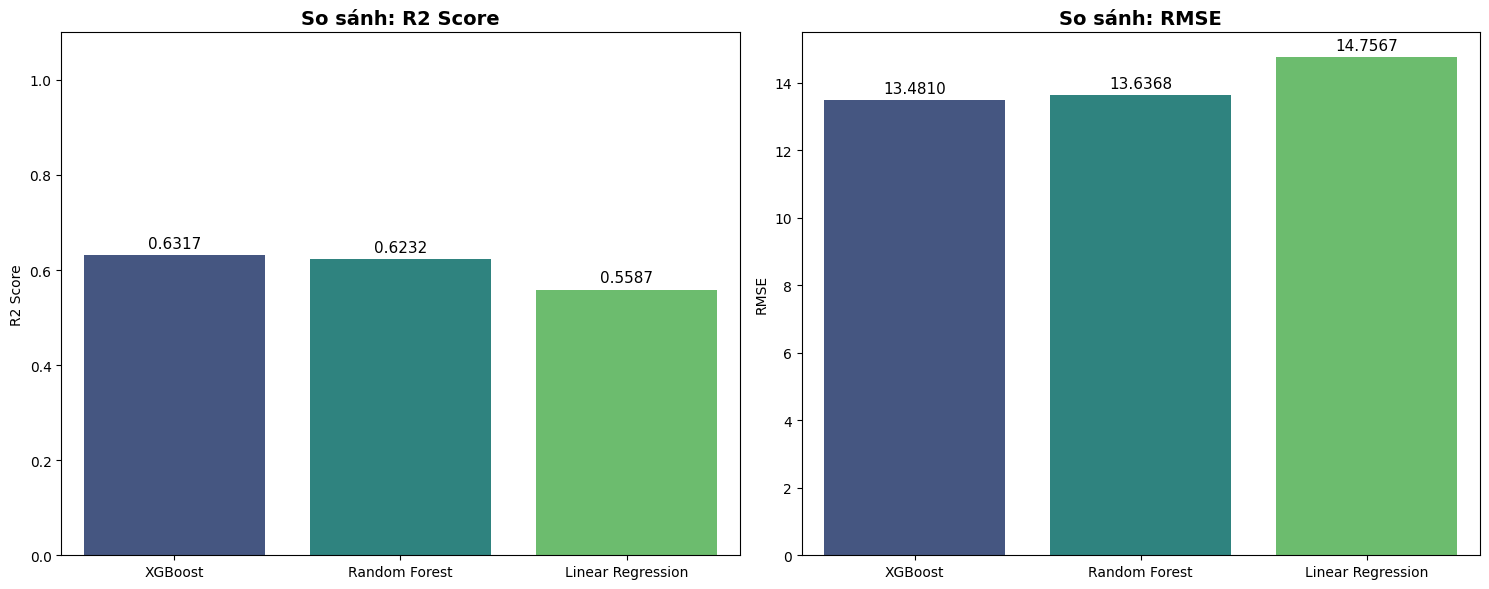

In [ ]:
# Xác định các chỉ số cần vẽ (R2 và RMSE)
metrics = results_df.columns[3:] 
num_plots = len(metrics)

# Tính toán layout
cols = 2
rows = math.ceil(num_plots / cols)

# Khởi tạo khung hình
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
axes = axes.flatten() # Làm phẳng mảng axes để dễ truy cập bằng chỉ số i

for i, col in enumerate(metrics):
    sns.barplot(data=results_df, x='Model', y=col, ax=axes[i], palette='viridis', hue='Model')
    
    axes[i].set_title(f'So sánh: {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)
    
    # Hiển thị con số trên đầu cột
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.4f', padding=3, fontsize=11)
    
    # Tùy chỉnh trục Y: R2 thì giới hạn 0-1, RMSE thì để tự nhiên
    if 'R2' in col:
        axes[i].set_ylim(0, 1.1)

# Ẩn các ô biểu đồ thừa
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **Độ phù hợp ($R^2$ Score)**
    - **Linear Regression:** Đạt $R^2 = 0.5587$. Đây là kết quả thấp nhất trong ba mô hình. Mặc dù con số này cho thấy mô hình vẫn giải thích được hơn 55% sự biến thiên của dữ liệu (tức là có tồn tại mối quan hệ tuyến tính nhất định), nhưng nó kém hiệu quả hơn hẳn so với hai đối thủ còn lại.
    - **Random Forest**: Đạt $R^2 = 0.6232$. Kết quả cải thiện đáng kể so với Linear Regression. Mô hình đã nắm bắt tốt hơn các mẫu dữ liệu, nâng khả năng giải thích lên khoảng 62.3%.
    - **XGBoost:** Đạt $R^2 = 0.6317$. Đây là mô hình hoạt động tốt nhất. Tuy nhiên, mức chênh lệch so với Random Forest là rất nhỏ ($\approx 0.0085$), cho thấy hai thuật toán dạng cây này có sức mạnh tương đương nhau trên tập dữ liệu này.
- **Sai số tuyệt đối (RMSE)**
    - **Linear Regression:** RMSE = 14.7567. Sai số dự đoán trung bình cao nhất, lệch gần 15 đơn vị so với thực tế. Điều này đồng nhất với chỉ số $R^2$ thấp nhất ở trên.
    - **Random Forest:** RMSE = 13.6368. Sai số đã giảm hơn 1 đơn vị so với mô hình tuyến tính.
    - **XGBoost:** RMSE = 13.4810. Đạt mức sai số thấp nhất. Việc giảm thiểu RMSE so với Linear Regression khẳng định mô hình này đưa ra các dự đoán sát với thực tế nhất.
- **Nhận xét:**
    - **Dữ liệu có tính Phi tuyến:** Việc Linear Regression thua kém rõ rệt so với hai mô hình tổ hợp là Random Forest và XGBoost chứng tỏ mối quan hệ giữa các đặc trưng đầu vào và biến mục tiêu chứa đựng nhiều yếu tố phi tuyến tính mà một đường thẳng hồi quy đơn giản không thể bao quát hết.

##### Trực quan hóa mức độ quan trọng của các đặc trưng

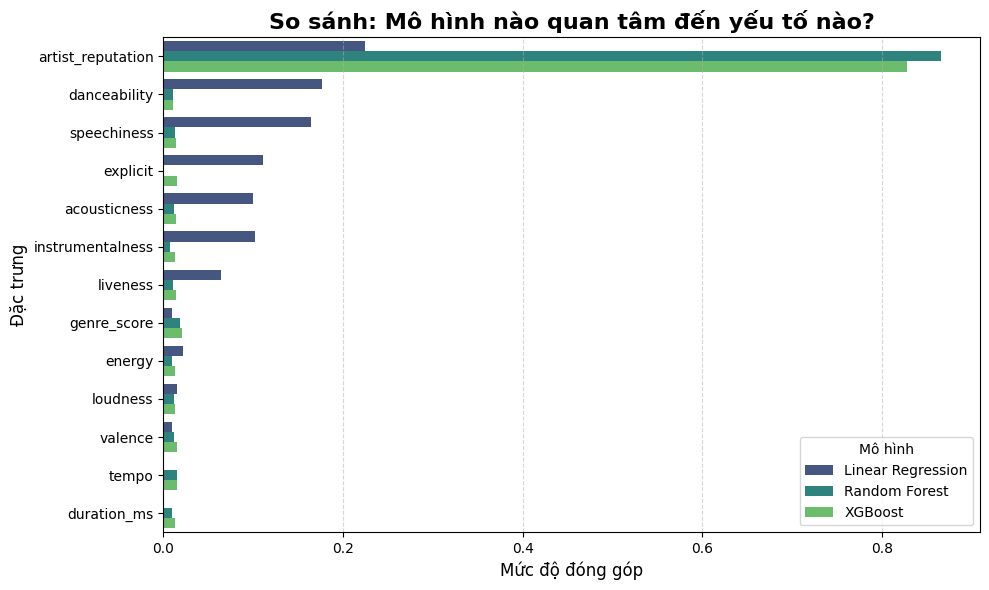

In [357]:
feature_names = X_train.columns.tolist()

# Tạo list chứa dữ liệu để vẽ
data_viz = []

for name, model in models.items():
    # Lấy giá trị quan trọng
    if name == "Linear Regression":
        # Với hồi quy tuyến tính, độ quan trọng xấp xỉ trị tuyệt đối của hệ số
        importances = np.abs(model.coef_)
    else:
        importances = model.feature_importances_
    
    # Chuẩn hóa về % (để cột LR không bị quá to hoặc quá nhỏ so với 2 model còn lại)
    if np.sum(importances) > 0:
        importances = importances / np.sum(importances)
    
    # Đưa vào danh sách
    for i, feat in enumerate(feature_names):
        data_viz.append({
            'Feature': feat,
            'Importance': importances[i],
            'Model': name
        })

# Tạo DataFrame tổng hợp
df_imp_all = pd.DataFrame(data_viz)

# Sắp xếp theo độ quan trọng trung bình giảm dần
order = df_imp_all.groupby('Feature')['Importance'].mean().sort_values(ascending=False).index

# Vẽ biểu đồ Grouped Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp_all, x='Importance', y='Feature', hue='Model', order=order, palette='viridis')

plt.title('So sánh: Mô hình nào quan tâm đến yếu tố nào?', fontsize=16, fontweight='bold')
plt.xlabel('Mức độ đóng góp', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(title='Mô hình', loc='lower right')
plt.tight_layout()
plt.show()

- **Đặc trưng ảnh hướng nhất (artist_reputation)**:
    - Đây là yếu tố ảnh hưởng lớn nhất đối với các mô hình cây (Random Forest, XGBoost) với mức đóng góp áp đảo (trên 0.8). Điều này cho thấy các mô hình này đã học được một quy luật đơn giản nhưng hiệu quả: "Danh tiếng nghệ sĩ quyết định phần lớn sự thành công của bài hát".
    - Với Linear Regression, dù đây vẫn là yếu tố quan trọng nhất, nhưng trọng số chỉ khoảng 0.2, cho thấy mô hình tuyến tính không thể tận dụng triệt để sức mạnh của biến này như các mô hình phi tuyến.
- **Sự phân hóa về tư duy giữa các mô hình (danceability, speechiness, explicit)**:
    - **Linear Regression:** Cố gắng tìm kiếm ý nghĩa từ các đặc trưng nội tại của bài hát. Nó cho rằng khả năng nhảy (danceability) hay lời nói (speechiness) có ảnh hưởng đáng kể đến kết quả.
    - **Random Forest/XGBoost**: Gần như phủ nhận vai trò của nhóm này (trọng số < 0.05). Các mô hình này cho rằng một khi đã biết danh tiếng nghệ sĩ, các yếu tố như bài hát có dễ nhảy hay không trở nên thừa thãi hoặc không đáng kể để xét đến.
- **Nhóm ít quan trọng (tempo, valence, loudness, energy)**:
    - Cả 3 mô hình đều đồng thuận rằng các thông số kỹ thuật thuần túy của âm thanh (nhịp độ, độ ồn, năng lượng) đóng góp rất ít vào việc dự đoán độ phổ biến (trọng số gần như sát đáy). Điều này gợi ý rằng người nghe nhạc quan tâm đến nghệ sĩ hơn là cấu trúc vật lý của âm thanh.

##### Trực quan hóa độ phổ biển thực tế và dự đoán của mô hình Random Forest

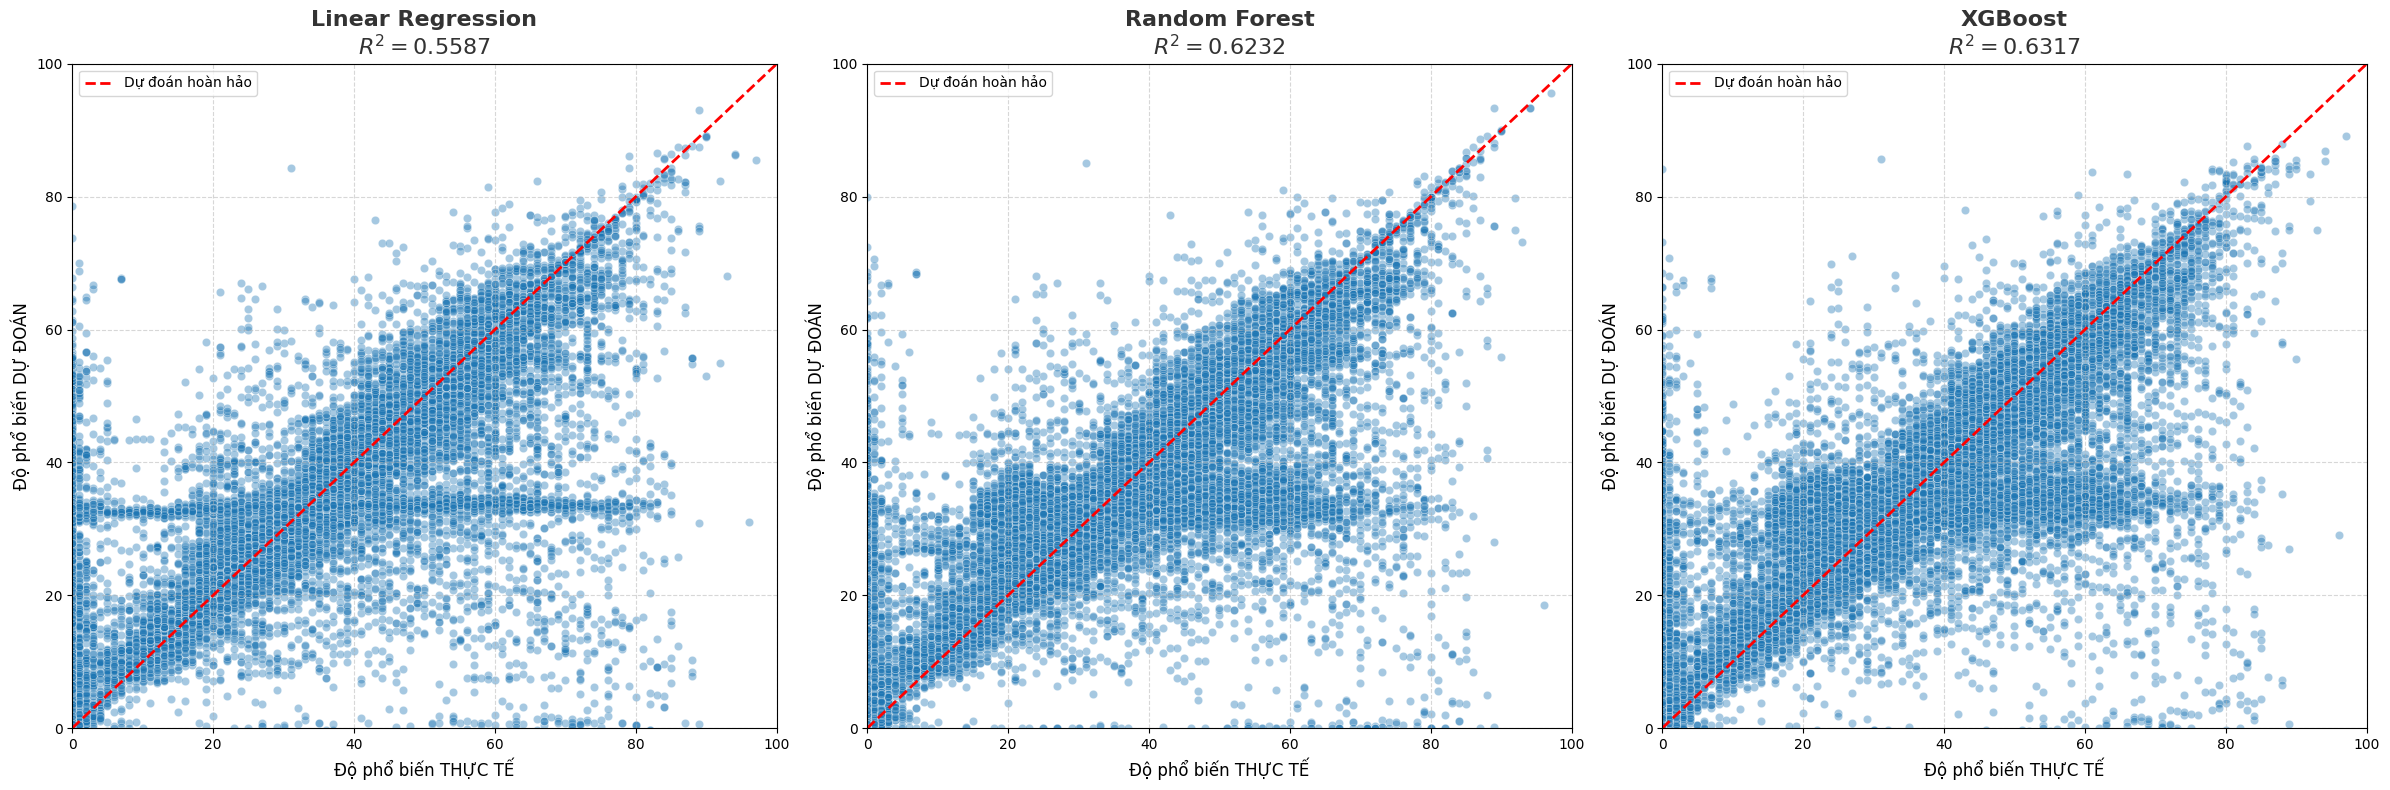

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Duyệt qua từng model trong danh sách models
for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]
    
    # Dự đoán
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # Vẽ điểm tán xạ (Scatter Plot)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, color='#1f77b4', ax=ax)
    
    # Vẽ đường chéo đỏ hoàn hảo (y = x)
    ax.plot([0, 100], [0, 100], color='red', linestyle='--', linewidth=2, label='Dự đoán hoàn hảo')
    
    ax.set_title(f'{name}\n$R^2 = {r2:.4f}$', fontsize=16, fontweight='bold', color='#333333')
    ax.set_xlabel('Độ phổ biến THỰC TẾ', fontsize=12)
    ax.set_ylabel('Độ phổ biến DỰ ĐOÁN', fontsize=12)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

- **Ảo tưởng tại điểm 0**
    - **Quan sát:** Có rất nhiều điểm dữ liệu mà thực tế độ phổ biến bằng 0 (nằm sát trục tung bên trái), nhưng mô hình lại dự đoán độ phổ biến rất cao, dao động từ 20 đến 60, thậm chí gần 80.
    - **Nhận định:** Mô hình đang bị đánh lừa bởi các đặc trưng nội tại của bài hát. Những bài hát này có thể có chỉ số âm thanh (danceability, energy...) chuẩn Hit hoặc thuộc thể loại nhạc hot, nhưng thực tế lại không có người nghe.
    - **Nguyên nhân tiềm ẩn (Phân hóa theo mô hình):**
        - **Với Linear Regression:** Do mô hình này phân phối trọng số cho các yếu tố âm nhạc (danceability, speechiness) khá cao (như biểu đồ trước đã chỉ ra), nên nó ngây thơ cho rằng nhạc hay tự khắc sẽ nổi, dẫn đến sai số lớn khi bài hát hay nhưng ca sĩ vô danh.
        - **Với Random Forest/XGBoost:** Dù rất quan tâm đến danh tiếng nghệ sĩ, nhưng việc vẫn dự đoán sai ở điểm 0 cho thấy có thể dữ liệu bị nhiễu (bài hát của ca sĩ nổi tiếng nhưng bị lỗi/chưa viral) hoặc mô hình chưa học được cách phạt nặng các bài hát có artist_reputation thấp.
- **Không thể bắt được "Hit":**
    - **Quan sát:** Ở vùng độ phổ biến thực tế rất cao ( > 80), hầu hết các điểm dự đoán đều nằm dưới đường hoàn hảo. Tức là mô hình dự đoán thấp hơn thực tế.
    - **Nhận định:** Mô hình gặp khó khăn trong việc nhận diện các siêu phẩm (Outliers). Nó có xu hướng an toàn, kéo các giá trị cực đại về phía trung bình.
    - **Nguyên nhân kỹ thuật:** Đây là hạn chế thường thấy của các mô hình dạng cây (Random Forest/XGBoost). Chúng không thể ngoại suy ra ngoài khoảng giá trị lớn nhất mà chúng đã thấy trong tập huấn luyện, dẫn đến hiện tượng bị chặn trần ở các giá trị cực cao.
- **Hiện tượng Vạch kẻ ngang:**
    - **Quan sát:** Đặc biệt rõ ở biểu đồ Linear Regression, xuất hiện các vệt ngang nơi nhiều điểm dữ liệu thực tế khác nhau nhưng lại được dự đoán ra cùng một giá trị y hệt.
    - Điều này tố cáo mô hình Linear Regression quá đơn giản. Có vẻ như nó đang dựa quá nhiều vào một vài biến phân loại (như track_genre hoặc một biến rời rạc nào đó) để đoán mò. Khi các biến liên tục khác không đủ mạnh để tác động, mô hình chỉ đơn giản là gán một giá trị trung bình cho cả một nhóm thể loại, tạo ra các vạch ngang thiếu tự nhiên này. XGBoost và Random Forest đã xử lý vấn đề này tốt hơn nhiều với đám mây điểm mượt mà hơn.

### **Kết luận về khả năng dự đoán**

- **Mô hình tuyến tính lạc lối:**
    - Các đặc trưng âm thanh (như danceability, energy...) không tác động đơn lẻ, cộng gộp tuyến tính lên độ phổ biến. Việc cố gắng áp đặt một đường thẳng vào mối quan hệ phức tạp này khiến Linear Regression thất bại trong việc nắm bắt các quy luật thực tế, dẫn đến việc nó dự đoán mò dựa trên các nhóm thể loại chung chung.
- **Mô hình Ensemble (XGBoost/RF) khả quan ($R^2 \approx 0.63$):**
    - Kết quả thực tế trên biểu đồ ($0.62 - 0.63$). Điều này khẳng định rằng khi chúng ta cho phép mô hình học các quy luật phi tuyến và tập trung vào danh tiếng nghệ sĩ, ta có thể giải thích được hơn 60% sự biến thiên của dữ liệu. Đây là mức chấp nhận được để tham khảo, nhưng chưa đủ để dùng làm công cụ dự đoán chính xác tuyệt đối.
- **Tại sao không cao hơn?**
    - Con số $R^2 \approx 0.63$ cho thấy mô hình đã chạm tới ngưỡng trần của bộ dữ liệu này. ~37% còn lại của sự thật nằm ở những yếu tố ngoài luồng mà mô hình hoàn toàn mù, bao gồm:
        - **Marketing:** Một bài hát dở nhưng được đổ tiền chạy quảng cáo, nằm trên Top trang chủ Spotify vẫn sẽ có độ phổ biến cao.
        - **Yếu tố Viral/Mạng xã hội:** Một đoạn nhạc trở thành trend trên TikTok có thể cứu cả một bài hát (yếu tố may mắn haythời điểm).
        - **Thời điểm phát hành:** Nhạc Giáng sinh chỉ hot vào tháng 12. Dữ liệu hiện tại có thể thiếu thời gian.
        - **Lời bài hát:** Mô hình chỉ phân tích âm thanh, nhưng khán giả thường nghe vì lời bài hát hay hoặcý nghĩa.
        - **Fanbase:** Độ trung thành của fan hâm mộ có thể tạo ra các chỉ số ảo mà chất lượng âm thanh không giải thích được.